In [2]:
import os
import json
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt
from PIL import Image
import pytesseract

# Load Data
data_dir = 'TextOCR/train_val_images/train_images'
annot_df = pd.read_csv('TextOCR/annot.csv')

# Extract unique image IDs
image_ids = annot_df['image_id'].unique()

# Split Data
train_ids, test_ids = train_test_split(image_ids, test_size=0.03, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.2, random_state=42)


In [3]:
# Create directories for images and labels
os.makedirs('dataset/images', exist_ok=True)
os.makedirs('dataset/labels', exist_ok=True)

# Function to convert bounding boxes to YOLO format
def convert_to_yolo_format(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[2]) / 2.0 - 1
    y = (box[1] + box[3]) / 2.0 - 1
    w = box[2] - box[0]
    h = box[3] - box[1]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

# Copy images and create label files in YOLO format
for image_id in image_ids:
    img_path = os.path.join(data_dir, f'{image_id}.jpg')
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    
    # Copy image to dataset/images
    new_img_path = os.path.join('dataset/images', f'{image_id}.jpg')
    cv2.imwrite(new_img_path, img)
    
    # Create label file
    records = annot_df[annot_df['image_id'] == image_id]
    boxes = records['bbox'].apply(json.loads).tolist()
    boxes = [[b[0], b[1], b[0] + b[2], b[1] + b[3]] for b in boxes]
    
    label_file_path = os.path.join('dataset/labels', f'{image_id}.txt')
    with open(label_file_path, 'w') as f:
        for box in boxes:
            yolo_box = convert_to_yolo_format((w, h), box)
            f.write(f'0 {yolo_box[0]} {yolo_box[1]} {yolo_box[2]} {yolo_box[3]}\n')
            
# Create the text files listing paths to images
def create_text_file(image_ids, file_path):
    with open(file_path, 'w') as f:
        for image_id in image_ids:
            img_path = os.path.join(os.getcwd(), 'dataset/images', f'{image_id}.jpg')
            f.write(f'{img_path}\n')

create_text_file(train_ids, 'dataset/train.txt')
create_text_file(val_ids, 'dataset/val.txt')
create_text_file(test_ids, 'dataset/test.txt')

print("Text files created successfully.")

Text files created successfully.


In [4]:
# Custom Dataset Class
class TextOCRDataset(Dataset):
    def __init__(self, image_ids, annot_df, data_dir, transforms=None):
        self.image_ids = image_ids
        self.annot_df = annot_df
        self.data_dir = data_dir
        self.transforms = transforms

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.data_dir, f'{image_id}.jpg')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.0

        records = self.annot_df[self.annot_df['image_id'] == image_id]
        boxes = records['bbox'].apply(json.loads).tolist()
        boxes = [[b[0], b[1], b[0] + b[2], b[1] + b[3]] for b in boxes]

        target = {}
        target['boxes'] = torch.as_tensor(boxes, dtype=torch.float32)
        target['labels'] = torch.ones((len(boxes),), dtype=torch.int64)  # Assuming all boxes contain text

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_ids)

# Data Transforms
transform = T.Compose([
    T.ToTensor()
])

In [5]:
# Reduced subset for quicker training
subset_ratio = 0.1  # Use 10% of the dataset for training
small_train_ids, _ = train_test_split(train_ids, test_size=1 - subset_ratio, random_state=42)
small_train_dataset = TextOCRDataset(small_train_ids, annot_df, data_dir, transforms=transform)

# Custom collate function to handle images of different sizes
def collate_fn(batch):
    return tuple(zip(*batch))

# Create smaller data loader with custom collate function
small_train_loader = DataLoader(small_train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_dataset = TextOCRDataset(val_ids, annot_df, data_dir, transforms=transform)
test_dataset = TextOCRDataset(test_ids, annot_df, data_dir, transforms=transform)

val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

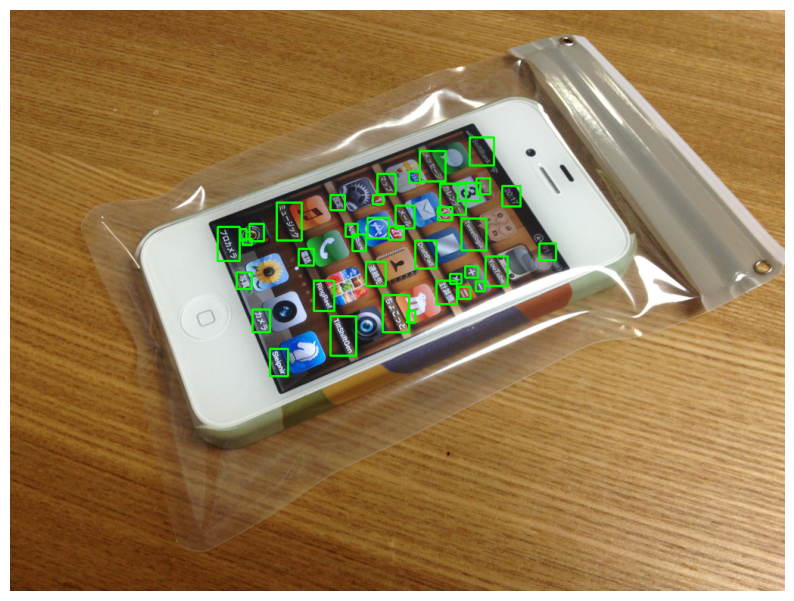

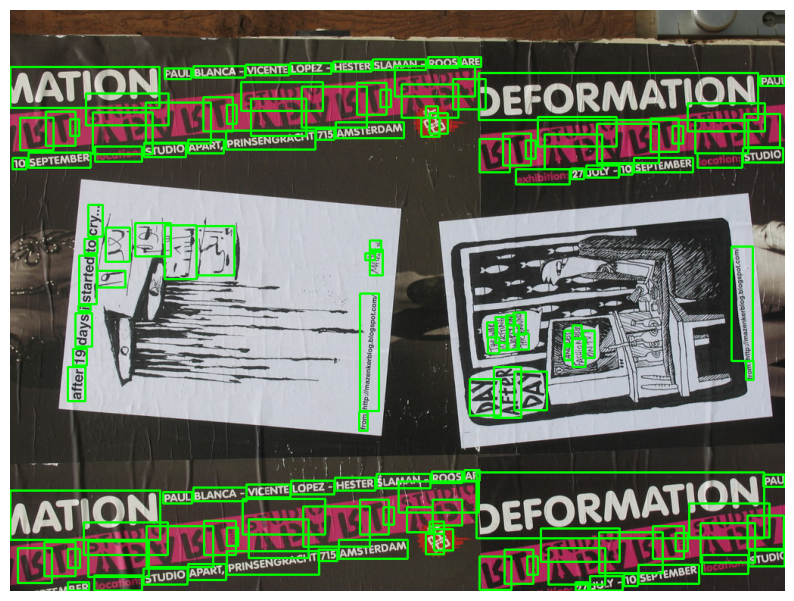

In [4]:
# Visualize Dataset
def visualize_data(dataset, idx=0):
    img, target = dataset[idx]
    boxes = target['boxes'].cpu().numpy()
    img = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Visualize some training data
visualize_data(small_train_dataset, idx=0)
visualize_data(small_train_dataset, idx=1)


In [7]:
from ultralytics import YOLO
model = YOLO('yolov3u.pt')
# Train YOLOv3
model.train(data='config.yaml', epochs=2, imgsz=640, batch=2, device='cpu')


Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\yushe\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 198M/198M [00:47<00:00, 4.35MB/s] 


Ultralytics 8.3.18  Python-3.11.10 torch-2.3.1 CPU (AMD Ryzen 7 7840H w/ Radeon(TM) 780M Graphics)
engine\trainer: task=detect, mode=train, model=yolov3u.pt, data=config.yaml, epochs=2, time=None, patience=100, batch=2, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

100%|██████████| 755k/755k [00:00<00:00, 6.15MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 1]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     37056  ultralytics.nn.modules.block.Bottleneck      [64, 64]                      
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    295680  ultralytics.nn.modules.block.Bottleneck      [128, 128]                    
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  8   4724736  ultralytics.nn.modules.block.Bottleneck      [256, 256]                    
  7                  -1  1   1180672  ultralytics

train: Scanning c:\Project\vscode\SSY340-text-extraction-project\dataset\labels... 16899 images, 0 backgrounds, 5 corrupt: 100%|██████████| 16899/16899 [00:32<00:00, 513.80it/s]

train: WARNING  c:\Project\vscode\SSY340-text-extraction-project\dataset\images\21b6bde202d35e2d.jpg: 1 duplicate labels removed
train: WARNING  c:\Project\vscode\SSY340-text-extraction-project\dataset\images\3e3b5093bb67a22f.jpg: ignoring corrupt image/label: negative label values [-0.00038067]
train: WARNING  c:\Project\vscode\SSY340-text-extraction-project\dataset\images\ae6e75dc8e157ff8.jpg: ignoring corrupt image/label: negative label values [-1.0842022e-19]
train: WARNING  c:\Project\vscode\SSY340-text-extraction-project\dataset\images\caedb5851c642d53.jpg: ignoring corrupt image/label: negative label values [-0.00032258]
train: WARNING  c:\Project\vscode\SSY340-text-extraction-project\dataset\images\dfc9486b33fbf05c.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0007427]
train: WARNING  c:\Project\vscode\SSY340-text-extraction-project\dataset\images\f593c9350c399d59.jpg: ignoring corrupt image/label: negative label values [-7.8125e-05]


train: New cache created: c:\Project\vscode\SSY340-text-extraction-project\dataset\labels.cache


val: Scanning c:\Project\vscode\SSY340-text-extraction-project\dataset\labels... 4225 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4225/4225 [00:08<00:00, 520.97it/s]

val: WARNING  c:\Project\vscode\SSY340-text-extraction-project\dataset\images\fc7029d496074b05.jpg: 1 duplicate labels removed


val: New cache created: c:\Project\vscode\SSY340-text-extraction-project\dataset\labels.cache
Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 84 weight(decay=0.0), 91 weight(decay=0.0005), 90 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G      1.942      1.622      1.354        190        640:   8%|▊         | 717/8447 [1:30:39<16:17:23,  7.59s/it]


KeyboardInterrupt: 

In [ ]:
def extract_text_from_bbox(image, bbox):
    x1, y1, x2, y2 = bbox
    roi = image[int(y1):int(y2), int(x1):int(x2)]
    roi = Image.fromarray(roi)
    text = pytesseract.image_to_string(roi)
    return text

def recognize_text(model, dataset):
    model.eval()
    detections = []
    for img, _ in dataset:
        with torch.no_grad():
            results = model(img.unsqueeze(0))  # Perform inference
            bboxes = results.xyxy[0].cpu().numpy()  # Extract bounding boxes
            detected_texts = []
            img = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            
            for bbox in bboxes:
                text = extract_text_from_bbox(img, bbox)
                detected_texts.append(text)
            detections.append(detected_texts)
    return detections

detected_texts = recognize_text(model, test_dataset)

# Visualize some test data with recognized text
def visualize_recognition(dataset, detected_texts, idx=0):
    img, _ = dataset[idx]
    img = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    for bbox, text in zip(detected_texts[idx], detected_texts[idx]):
        x1, y1, x2, y2 = map(int, bbox[:4])
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, text, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

visualize_recognition(test_dataset, detected_texts, idx=0)
visualize_recognition(test_dataset, detected_texts, idx=1)